# Multiscale Point Cloud Neural Operator

The [Multiscale Point Cloud Neural Operator (MPCNO)](https://arxiv.org/abs/2602.01498) is a neural network - based surrogate model framework meticulously designed to approximate solution maps of parametric partial differential equations (PDEs) on intricate and variable geometries. Given an abstract parametric PDE $$\mathcal{R}(u, a) = 0$$ defined on $\Omega \subset \mathbb{R}^{d}$, where $\mathcal{R}$ represents a generalized differential operator, $a: \mathbb{R}^{d} \to \mathbb{R}^{d_{a}}$ stands for the parameter function, and $u(x): \mathbb{R}^{d} \to \mathbb{R}^{d_{u}}$ denotes the solution function. The overarching objective of MPCNO is to approximate the solution map 
$$\mathcal{G}^{\dagger}:(a, \Omega) \mapsto u.$$

Motivated by classical boundary integral formulations, which express PDE solutions via kernel integration, 

$$u(x) = \int_{\mathcal{D}} \kappa(x-y,n_x,n_y)a(y)dy$$

where $\mathcal{D}$ denotes either the domain $\Omega$ or its boundary $\partial\Omega$, and $n_x$ and $n_y$ are the outward unit normal vectors (when applicable). We propose to construct neural operators from learnable linear kernel integral operators combined with pointwise nonlinearities. These integral operators act directly on functions defined over variable geometries, serving as the linear layers (analogous to 
$y=Wx+b$) in the network architecture. Crucially, this approach circumvents the need for explicit geometric parameterization—geometric information is inherently incorporated into the kernel integrals and can be efficiently evaluated over point cloud discretizations.

However, many integral kernels of interest are singular (e.g., the fundamental solution of the Laplace equation). Directly learning such singular kernels through global integral operators is challenging. To address this, we decompose the kernel into a smooth long-range component and a localized short-range component. The smooth part is efficiently learned via Fourier type kernel-integral representations, while the singular short-range interactions are handled through local geometric approximations, leading to a stable and accurate multiscale model MPCNO.

## Multiscale Point Cloud Neural Operator

The Multiscale Point Cloud neural layer $\mathcal{L}$ serves to map the input function $f_{\rm in}: \Omega \rightarrow \mathbb{R}^{d_{\rm in}}$ to the output function $f_{\rm out}: \Omega \rightarrow \mathbb{R}^{d_{\rm out}}$. This mapping is defined as follows:
$$
\begin{equation*}
\begin{split}
    &\mathcal{L} : f_{\rm in} \mapsto f_{\rm out}, \\
    &f_{\rm out}(x) =  f_{\rm in}(x) + \sigma(\mathbb{K}_{\rm long}f_{\rm in}(x)+\mathbb{K}_{\rm short}f_{\rm in}(x)).\
\end{split}
\end{equation*}
$$


Here, $\mathbb{K}_{\rm long}$ and $\mathbb{K}_{\rm short}$ are representatively used to approximate the long-range component and short-range component in the kernel integral
$$(\mathcal{K}f)(x) = \int_\mathcal{D} \kappa(x-y,n_x,n_y)f(y)dy$$

That means:
$$\mathbb{K}_{\rm long}f(x) \approx \int_{\mathcal{D}}\kappa_{\rm long}(x-y,n_x,n_y)f(y)dy$$
$$\mathbb{K}_{\rm short}f(x) \approx \int_{\mathcal{D}}\kappa'(x-y,n_x,n_y)f(y)dy$$
here $\kappa_{\rm long}$ is the smooth part and $\kappa_{\rm short}$ is the local part (near-field portion). The existance of such decomposition (spliting the singular kernel $\kappa$ into two, one smooth enough to be approximated through Fourier bases, another one local enough that can be approximated in a local region) is proven.

$$\mathbb{K}_{\rm long}^{(1)} f(x)
=  \sum_{k}  \int_{\partial \Omega} e^{2\pi i k \cdot\frac{x - y}{2l}} W_{v,1}^{k}  W_1 \begin{bmatrix}
    f(y)  \\ 
    f(y) \otimes n_y 
\end{bmatrix} \rm{d} y$$
$$
\mathbb{K}_{\rm long} f(x)
=  W_3 \mathbb{K}_{\rm long}^{(1)} f(x) + W_2 \begin{bmatrix}
\mathbb{K}_{\rm long}^{(1)} f(x)\\
\mathbb{K}_{\rm long}^{(1)} f(x) \otimes n_x
\end{bmatrix},
$$

$$\mathbb{K}_{\rm short} f(x)
=  \begin{cases}
    \displaystyle W_{l}f(x) + b +  W_{g,1}\nabla_{\mathcal{D}}f (x)  & \mathcal{D} = \Omega \\
    \begin{aligned}\displaystyle   W_{l}f(x) + b +  W_{g,1}\nabla_{\mathcal{D}}f (x) 
    &+ W_{g,2}\Bigl(W_{g,3}
    \begin{bmatrix}
     n_x \\  \nabla_{\mathcal{D}}  n_x 
    \end{bmatrix} \odot W_{g,4} f (x)\Bigr) 
     \end{aligned}  & \mathcal{D} = \partial \Omega,
\end{cases}
$$

In our programmes, we introduce smooth function to avoid numerical instabilities in gradient computing.

$$\mathbb{K}_{\rm short} f(x)
=  \begin{cases}
    \displaystyle W_{l}f(x) + b +  W_{g,1}^{(1)}\sigma(W_{g,1}^{(2)}\nabla_{\mathcal{D}}f (x))  & \mathcal{D} = \Omega \\
    \begin{aligned}\displaystyle   W_{l}f(x) + b +  W_{g,1}^{(1)}\sigma(W_{g,1}^{(2)}\nabla_{\mathcal{D}}f (x)) 
    &+ W_{g,2}\Bigl(\sigma(W_{g,3}
    \begin{bmatrix}
     n_x \\  \nabla_{\mathcal{D}}  n_x 
    \end{bmatrix}) \odot W_{g,4} f (x)\Bigr) 
     \end{aligned}  & \mathcal{D} = \partial \Omega,
\end{cases}
$$
here the operator $\odot$ means element-wise product. And $\sigma$ is usually set to be :$SoftSign(x)=\frac{x}{1+|x|}$


## Parametrization and Computation 

### integral operator

The integral operator is formulated as:
$$
f_{\rm out}(x)=\sum_k \int_{\Omega} e^{2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y) {\rm d}y
$$
where $W_k^{v} \in \mathbb{C}^{d_{out} \times d_{in}}$ is a parameter matrix. 

Compared with PCNO, we omit the explicit density term $\rho(y;\Omega)$ in the integral formulation. The role of $\rho(y;\Omega)$ is to provide a normalized measure for the domain Ω. In practice, we found that setting $\rho(y;\Omega)$ to a constant (i.e., $\rho\equiv C$) leads to similar or even improved performance, while simplifying both implementation and analysis. Hence, in our architecture, the density is absorbed into the numerical quadrature weights, and for clarity of exposition, we omit it from the integral notation.

Consider a set of bases $\{\phi_k\}$ on $\Omega$. We define the weighted bases $\{\phi_{w,k}\}$ as
$$\phi_k(x) = e^{2\pi i\frac{k}{L}x}, \quad \phi_{w,k}(x_i) =  \overline{\phi_k(x_i)}{\rm d}\Omega_i$$
Then, we can rewrite the integral operator as follows:
$$
\begin{align*}
f_{\rm out}(x)&=\sum_k \int_{\Omega} e^{2\pi i\frac{k}{L}(x - y)}W_k^vf_{\rm in}(y){\rm d}y\\
&\approx  \sum_k\sum_i \phi_k(x)\overline{\phi_k(y_i)} W_k^vf_{\rm in}(y_i){\rm d}\Omega_i\\
&=  \sum_k \phi_k(x)W_k^v\sum_i\phi_{w,k}(y_i) f_{\rm in}(y_i)\\
&= \sum_k \phi_k(x)W_k^v\hat{f_{\rm in}}[k]\\
\end{align*}
$$

Since we are only concerned with the real part, to avoid complex - valued 
arithmetic operations, we can separately utilize the sine and cosine components. The computational process can be divided into three steps:

- **Step 1: Fourier - like Coefficient Computation**

Compute 
$$
\begin{align*}  
\hat{f}_{\rm in}^c[k] &= \langle\phi_{w,k}^c,f_{\rm in} \rangle ,\\
\hat{f}_{\rm in}^s[k] &= \langle\phi_{w,k}^s,f_{\rm in} \rangle,\\
\hat{f}_{\rm in}[0] &= \langle\phi_{w,0},f_{\rm in} \rangle.
\end{align*}$$
Here, $\phi_{w,k}^c$ and $\phi_{w,k}^s$ are the real part and the imaginary part of $\phi_{w,k}$ respectively. 

The corresponding codes are:
```python
x_c_hat =  torch.einsum("bix,bxkw->bikw", x, wbases_c)
x_s_hat = -torch.einsum("bix,bxkw->bikw", x, wbases_s)
x_0_hat =  torch.einsum("bix,bxkw->bikw", x, wbases_0)
```

- **Step 2: Transformed Coefficient Computation**

Compute
$$
\begin{align*}  
 &\widehat{Rf}^c_{\rm in}[k]  = R^c(k)\hat{f}^c_{\rm in}[k] - R^s(k)\hat{f}^s_{\rm in}[k] \\ 
 &\widehat{Rf}^s_{\rm in}[k] =  R^c(k)\hat{f}^s_{\rm in}[k] + R^s(k)\hat{f}^c_{\rm in}[k]  \\
 &\widehat{Rf}_{\rm in}[0] =  R^c(0)\hat{f}_{\rm in}[0]
\end{align*}$$
where $R^c(k)$ and $R^s(k)$ are real - valued martixs. The multiplication methods here originate from the complex multiplication of $W_k^v$.

The corresponding codes are:
```python
f_c_hat = torch.einsum("bikw,iokw->bokw", x_c_hat, weights_c) - torch.einsum("bikw,iokw->bokw", x_s_hat, weights_s)
f_s_hat = torch.einsum("bikw,iokw->bokw", x_s_hat, weights_c) + torch.einsum("bikw,iokw->bokw", x_c_hat, weights_s)
f_0_hat = torch.einsum("bikw,iokw->bokw", x_0_hat, weights_0) 
```
- **Step 3: Output Function Reconstruction**
$$
\begin{align*}
f_{\rm out} = \widehat{Rf}_{\rm in}[0]\phi_0 + 2\sum_k \widehat{Rf}_{\rm in}^c[k]\phi_k^c - 2\sum_k \widehat{Rf}_{\rm in}^s[k]\phi_k^s
\end{align*}$$
the factor of 2 and the negative sign here both come from taking the real part of the original complex multiplication.

The corresponding codes are:

```python
x = torch.einsum("bokw,bxkw->box", f_0_hat, bases_0)  
    + 2 * torch.einsum("bokw,bxkw->box", f_c_hat, bases_c) 
    - 2 * torch.einsum("bokw,bxkw->box", f_s_hat, bases_s)
```


### Differential Operator
We further define a differential operator to capture local effects. The gradient $\nabla f : \mathbb{R}^d\to\mathbb{R}^{d\times d_{in}}$ can be computed independently for each of the $d_{in}$ channels. For simplicity, we focus on the scalar function $f: \mathbb{R}^d \to \mathbb{R}$. 

Given a target node $x$ with neighbors $x^{(1)}, x^{(2)}, \ldots, x^{(m)}$, the fist order Tayler expansion is
$$
(x^{(i)} - x) \cdot\nabla f(x)\approx f(x^{(i)})-f(x)
$$

Therefore we estimate the gradient $\nabla f(x)$ by solving the least-squares problem:
$$
A(x)  \nabla f(x) = b_f(x)
$$
where
$$ A(x)  = \begin{pmatrix}
x^{(1)} - x\\
x^{(2)} - x\\
\vdots\\
x^{(m)} - x\\
\end{pmatrix} \in \mathbb{R}^{m \times d}
$$
and
$$
b_f(x) =  
 \begin{pmatrix}
f(x^{(1)}) - f(x)\\
f(x^{(2)}) - f(x)\\
\vdots\\
f(x^{(m)}) - f(x)\\
\end{pmatrix} \in \mathbb{R}^{m}.
$$

#### Compute the Pseudo-Inverse

The least-squares problem can be solved by computing the pseudo-inverse $A(x)^{\dagger} \in \mathbb{R}^{d \times m} $.  Since $A(x)^{\dagger}$ depends solely on the point cloud and its connectivity, it can be preprocessed before training.

- **Step 1: Truncated SVD**
  
    Special consideration is required when $\Omega$ is a submanifold of $\mathbb{R}^d$. Let $d^{'} \leq d$ denote the intrinsic dimension of $\Omega$. The truncated singular value decomposition of $A(x)$ with rank $d^{'}$ is given by
    $$
        A(x) = U\Sigma V^T
        
    $$
    where
    $$
     U\in \mathbb{R}^{m \times d^{'}},\quad\Sigma \in \mathbb{R}^{d^{'} \times d^{'}}, \quad V^T\in \mathbb{R}^{d^{'} \times d}.
    $$
    In practice, the rank $d^{'}$ is specified by the variable `rrank`, and a tolerance `rcond` is set to handle small singular values and avoid numerical instability.
    ```python
        u, s, vt = np.linalg.svd(a, full_matrices=False)
        cutoff = rcond * s[0]
        large = s > cutoff
        large[rrank:] = False
    ```

- **Step 2: Compute the Pseudo-Inverse**

    The pseudo-inverse is then computed as $A(x)^{\dagger} = V\Sigma^{-1} U^T$.
    ```python
        s = np.divide(1, s, where=large, out=s)
        s[~large] = 0
        res = np.matmul(np.transpose(vt), np.multiply(s[..., np.newaxis], np.transpose(u)))
    ```
 
 - **Step 3: Store On edges**
  
    The $i$-th column of $A(x)^{\dagger}$, denoted as $A_i(x)^{\dagger} \in \mathbb{R}^{d}$, can be stored at the directed edge $x \leftarrow x^{(i)}$ in `edge_gradient_weights`

#### Compute the gradient

The gradient $\nabla f(x) = A(x)^{\dagger}b_f(x)$ can be efficiently assembled using a message-passing procedure.

- **Step1: Compute the Message on Each Edge**
  
    For each directed edge $x\leftarrow x^{(i)}$, the message is computed as
    $$
    A_i(x)^{\dagger} \bigl(f(x^{(i)}) - f(x)\bigr)
    $$
    
    ```python
        target, source = directed_edges[...,0], directed_edges[...,1]
        message = torch.einsum('bed,bec->becd', edge_gradient_weights, f[torch.arange(batch_size).unsqueeze(1), source] - f[torch.arange(batch_size).unsqueeze(1), target]).reshape(batch_size, max_nedges, in_channels*ndims)
    ```
    
- **Step2: Aggregating the Information**
  
    Once the messages are computed, they need to be aggregated to form the gradient at each node. The gradient is the sum of all incoming messages to a node $x$
    $$
    \nabla f(x) = \sum_{x\leftarrow x^{(i)}} A_i(x)^{\dagger} \bigl(f(x^{(i)}) - f(x)\bigr).
    $$
    ```python
        f_gradients = torch.zeros(batch_size, max_nnodes, in_channels*ndims, dtype=message.dtype, device=message.device)
        f_gradients.scatter_add_(dim=1, src=message, index=target.unsqueeze(2).repeat(1,1,in_channels*ndims))
    ```

### Numerical Study
In the following, we test our algorithm by different examples

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from pcno.geo_utility import pinv
from pcno.pcno import compute_gradient

#### Example1: One Single point
Take $d = 2$, and suppose
$$f(x,y) = (x+1)^2 + (y+1)^2$$

We only consider 5 points 
$$x_0=(0,0), x_1 = (0,0.1), x_2=(0.1,0), x_3(0, -0.1), x_4(-0.1, 0)$$

[]

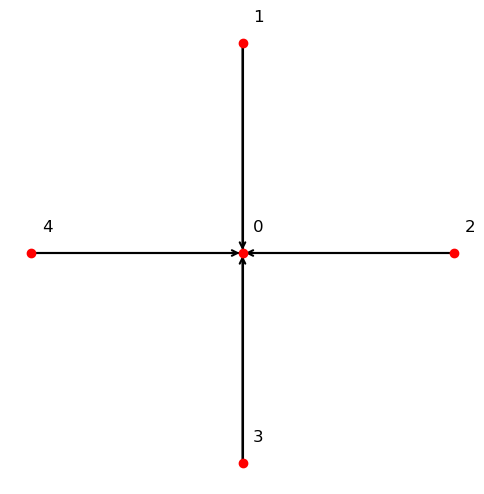

In [2]:
def fval(nodes):
    nnodes, _ = nodes.shape
    f = np.zeros((1, nnodes))
    for i in range(nnodes):
        f[0, i] = (nodes[i, 0] + 1) ** 2 + (nodes[i, 1] + 1) ** 2
    return f

nodes = np.zeros((5, 2))
nodes[1, :] = np.array([0, 0.1])
nodes[2, :] = np.array([0.1, 0])
nodes[3, :] = np.array([0, -0.1])
nodes[4, :] = np.array([-0.1, 0])
f = torch.tensor(fval(nodes)[np.newaxis, ...])

directed_edges = np.zeros((4, 2), dtype=int)
for i in range(4):
    directed_edges[i, :] = np.array([0, i + 1])

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(nodes[:, 0], nodes[:, 1], color="red", zorder=5)
for i, (x, y) in enumerate(nodes):
    ax.text(x + 0.01, y + 0.01, f"{i}", fontsize=12, ha="right")

for edge in directed_edges:
    node_start, node_end = nodes[edge[0], :], nodes[edge[1], :]
    ax.plot([node_start[0], node_end[0]],[node_start[1], node_end[1]],color="black", zorder=1)
    dx, dy = node_end[0] - node_start[0], node_end[1] - node_start[1]
    ax.annotate("", xy=(node_end[0], node_end[1]), xytext=(node_start[0], node_start[1]), arrowprops=dict(facecolor="black", arrowstyle="<-", lw=1.5), zorder=3)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

In [3]:
dx = nodes[1:, :]
edge_gradient_weight = pinv(dx, 2)

print(f"dx: \n{dx}")
print(f"weight: \n{edge_gradient_weight}")
print(f"weight * dx: \n{np.matmul(edge_gradient_weight, dx)}")

dx: 
[[ 0.   0.1]
 [ 0.1  0. ]
 [ 0.  -0.1]
 [-0.1  0. ]]
weight: 
[[ 0.00000000e+00  5.00000000e+00  0.00000000e+00 -5.00000000e+00]
 [ 5.00000000e+00 -6.26858359e-16 -5.00000000e+00  6.26858359e-16]]
weight * dx: 
[[ 1.00000000e+00  0.00000000e+00]
 [-1.25371672e-16  1.00000000e+00]]


Then we compute the gradient. The true gradient at $x_0$ is
$$\nabla f(x_0) = \begin{pmatrix}2\\ 2\end{pmatrix}$$
Since $x_0$ is the only target point, the result at other points should be 
$$\nabla f(x_i) = \begin{pmatrix}0\\ 0\end{pmatrix}, ~i\geq 1$$

In [4]:
directed_edges = torch.tensor(directed_edges[np.newaxis, ...])
edge_gradient_weight = torch.tensor(edge_gradient_weight[np.newaxis, ...]).permute(0, 2, 1)
gradient = compute_gradient(f, directed_edges, edge_gradient_weight)
print(gradient)

tensor([[[2.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], dtype=torch.float64)


#### Example2: Curve Test of Single Circle

In [5]:
def visualize_curve(nodes, features, ax=None, two_circles=False, add_colorbar=False, title = "", figurename=''):
    print(nodes.shape, features.shape)
    
    # 判断是否传入了ax
    if ax is None:
        # 没有传入ax，保持原来的行为
        plt.figure()
        ax = plt.gca()
    
    N = len(nodes) if not two_circles else len(nodes) // 2
    if two_circles:
        elems1 = np.stack([np.full(N, 1, dtype=int), np.arange(N), (np.arange(N) + 1) % N], axis=1)
        elems2 = np.stack([np.full(N, 1, dtype=int), np.arange(N, 2*N), (np.arange(N, 2*N) + 1 - N) % N + N], axis=1)
        elems = np.concatenate([elems1, elems2], axis=0)  # 2N, 3
    else:
        elems = np.stack([np.full(N, 1, dtype=int), np.arange(N), (np.arange(N)+1)%N], axis = 1)
    
    # 在ax上绘制
    scatter_g = ax.scatter(nodes[:, 0], nodes[:, 1], c=features, cmap='viridis', s=40)
    
    # 添加颜色条（只有单图模式才自动添加）
    if add_colorbar:
        plt.colorbar(scatter_g, ax=ax, label='g1(x)')
    
    if title:
        ax.set_title(title)
    ax.axis('equal')
    
    for elem in elems:
        node_indices = elem[1:]
        valid_indices = node_indices[node_indices != -1]
        if len(valid_indices) > 1:
            elem_nodes = nodes[valid_indices]
            ax.plot(elem_nodes[:, 0], elem_nodes[:, 1], color='red', linewidth=1, alpha=0.7)
    
    plt.tight_layout()
    
    if figurename:
        plt.savefig(figurename)
    
    # 返回scatter对象便于外部处理
    return scatter_g

In [12]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = np.load("../data/curve/pcno_curve_data_1_1_5_2d_sp_laplace_panel.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]
print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges)
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

Casting to tensor


torch.Size([1000, 2]) torch.Size([1000])
torch.Size([1000, 2]) torch.Size([1, 1000])
torch.Size([1000, 2]) torch.Size([1, 1000])


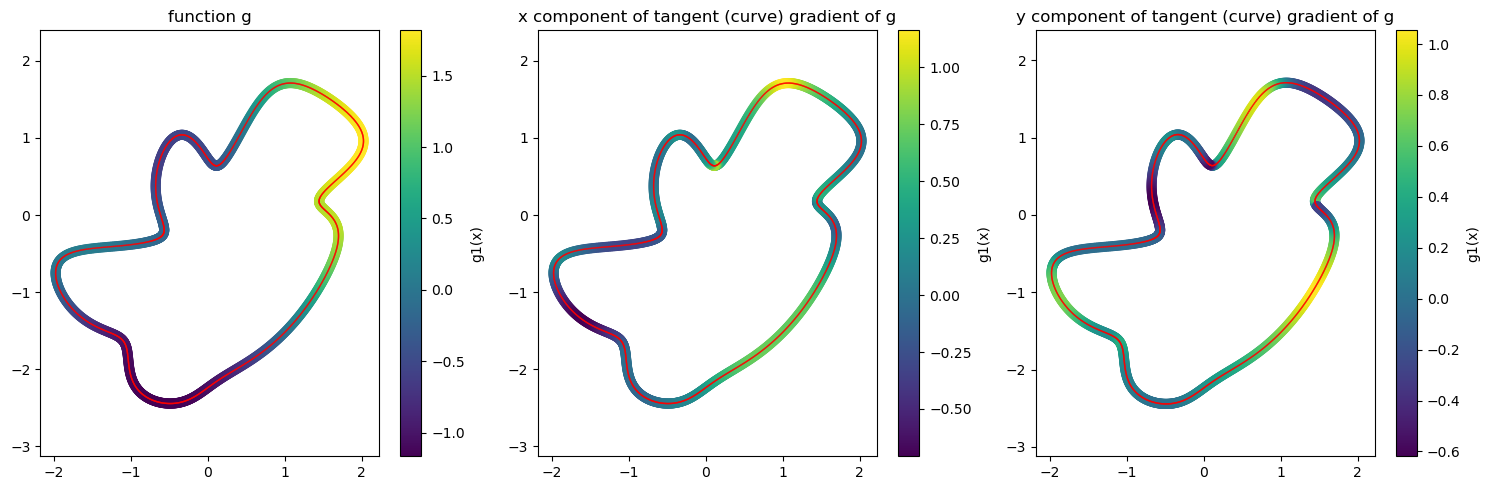

In [14]:
ind = 150
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = visualize_curve(nodes[ind],features[ind,:,3], ax=axes[0],title="function g",add_colorbar=True)

gradient = compute_gradient(features[[ind],:,3:4].permute(0,2,1),directed_edges[[ind]],edge_gradient_weights[[ind]])
ax2 = visualize_curve(nodes[ind],gradient[:,0,:], ax=axes[1],title="x component of tangent (curve) gradient of g",add_colorbar=True)
ax3 = visualize_curve(nodes[ind],gradient[:,1,:], ax=axes[2],title="y component of tangent (curve) gradient of g",add_colorbar=True)

#### Example3: Curve Test of Double Circle

In [15]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = np.load("../data/curve/pcno_curve_data_1_1_5_2d_sp_laplace_panel_two_circles.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]
print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges)
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

Casting to tensor


torch.Size([2000, 2]) torch.Size([2000])
torch.Size([2000, 2]) torch.Size([1, 2000])
torch.Size([2000, 2]) torch.Size([1, 2000])


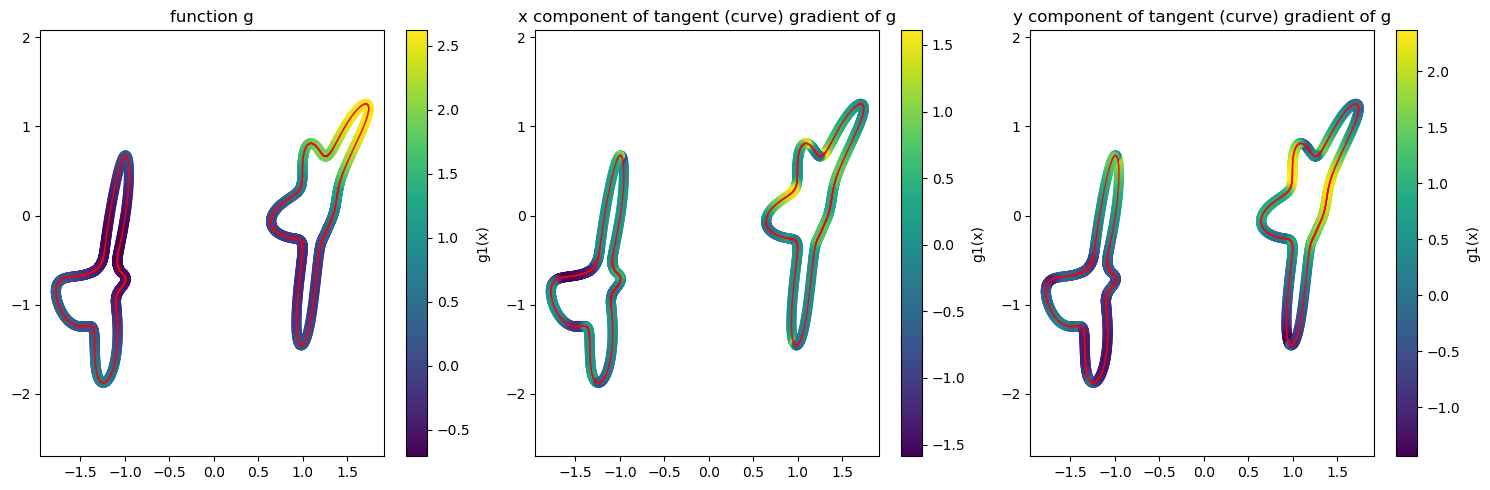

In [16]:
ind = 100
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = visualize_curve(nodes[ind],features[ind,:,3], ax=axes[0],title="function g",add_colorbar=True,two_circles=True)

gradient = compute_gradient(features[[ind],:,3:4].permute(0,2,1),directed_edges[[ind]],edge_gradient_weights[[ind]])
ax2 = visualize_curve(nodes[ind],gradient[:,0,:], ax=axes[1],title="x component of tangent (curve) gradient of g",add_colorbar=True,two_circles=True)
ax3 = visualize_curve(nodes[ind],gradient[:,1,:], ax=axes[2],title="y component of tangent (curve) gradient of g",add_colorbar=True,two_circles=True)